In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from collections import deque
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import loadBar
from csv_parser import CSVParser
from globals import RESOURCE_FOLDER, STEPSIZES, OUTPUT_WINDOW, INPUT_WINDOW, OUTPUT_FORECAST, DELETEABLE_COLUMNS, ONE_HOT_COLUMNS
from markovSquares import apply_markov
from feature_engineer import FeatureEngineer
from exploring_data_functions import *

from searoutePointFinder import fill_with_proximity

In [3]:
parser = CSVParser(RESOURCE_FOLDER)
total_df = parser.retrieve_training_data()

In [4]:
total_df["time"] = pd.to_datetime(total_df['time'])

In [5]:
def map_indexes_within_timewindow(df, time_col, timewindow):
    # Initialize the dictionary to store the mappings
    index_map = {}    

    within_window = deque()
    
    # Iterate over the DataFrame by index and row
    for current_idx in range(len((df))):
        current_row = df.iloc[current_idx]
        current_time = current_row[time_col]
        
        # Remove outdated timestamps from the left of the deque
        while within_window and (current_time - within_window[0][1] > timewindow):
            index_map[within_window[0][0]] = within_window[-1][0]
            within_window.popleft()
        
        # If this is the last row, map all the remaining indexes to this row
        if current_idx == df.index[-1]:
            for idx, _ in within_window:
                index_map[idx] = current_idx
        
        # Add the current index and time to the deque
        within_window.append((current_idx, current_time))
    
    return index_map

In [6]:
def calculate_time_diffs_within_window(df):
    result_list= []
    vessel_dfs = df.groupby('vesselId')
    j=0
    for _, vessel_df in vessel_dfs:
        j+=1
        loadBar.load_bar(len(vessel_dfs), j)
        
        vessel_df = vessel_df.sort_values(by='time')
        groups = vessel_df.groupby(pd.Grouper(key="time", freq='5D'))
        for _, group in groups:
                for i in range(len(group)):
                    current_row = group.iloc[0]
                    future_row = group.iloc[i]
                    new_row = current_row.copy()
                    new_row['next_latitude'] = future_row['latitude']
                    new_row['next_longitude'] = future_row['longitude']
                    new_row['time_diff'] = (future_row['time'] - current_row['time']).total_seconds()
                    result_list.append(new_row)
    
    print("Concating")
    result_df = pd.DataFrame(result_list)
    # result_df['diff_seconds'] = result_df['time_diff']
    # result_df['diff_minutes'] = result_df['diff_seconds'] / 60
    # result_df['diff_hours'] = result_df['diff_seconds'] / 3600
    # result_df['diff_days'] = result_df['diff_seconds'] / 86400
    
    # Identify the last row for each vesselId for separation
    last_rows = df.groupby('vesselId').tail(1)

    last_rows = last_rows.reset_index(drop=True)
    result_df
    
    return result_df, last_rows

In [7]:
def calculate_time_diffs_with_coords(df):
    # Ensure the DataFrame is sorted by vesselId and time
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    last_rows = df.groupby('vesselId').tail(1)
    # Calculate the time difference in seconds between consecutive times per vesselId
    df['time_diff'] = df.groupby('vesselId')['time'].diff().shift(-1)
    df['time_diff'] = df['time_diff'].dt.total_seconds()
    
    # Create columns for each time unit by converting from seconds
    # df['diff_seconds'] = df['time_diff'].dt.total_seconds()
    # df['diff_minutes'] = df['diff_seconds'] / 60
    # df['diff_hours'] = df['diff_seconds'] / 3600
    # df['diff_days'] = df['diff_seconds'] / 86400
    
    # Get the latitude and longitude of the next row within each vesselId group
    df['next_latitude'] = df.groupby('vesselId')['latitude'].shift(-1)
    df['next_longitude'] = df.groupby('vesselId')['longitude'].shift(-1)
    
    # Identify the last row for each vesselId
    
    
    # Remove the last rows from the main DataFrame
    df = df.drop(last_rows.index).reset_index(drop=True)
    last_rows = last_rows.reset_index(drop=True)
    
    # Drop the temporary 'time_diff' column
    df = df.drop(columns=['time_diff'])
    
    return df, last_rows

In [8]:
total_df, last_rows = calculate_time_diffs_within_window(total_df)

[====================] 100.0% complete
Concating


In [ ]:
#total_df.to_csv("filename.csv", index=False)

In [9]:
print(total_df.columns)

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',
       'longitude', 'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 'shippingLineId', 'CEU', 'DWT', 'GT',
       'NT', 'vesselType', 'breadth', 'depth', 'draft', 'enginePower',
       'freshWater', 'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed',
       'maxWidth', 'rampCapacity', 'yearBuilt', 'next_latitude',
       'next_longitude', 'time_diff', 'diff_seconds', 'diff_minutes',
       'diff_hours', 'diff_days'],
      dtype='object')


In [ ]:
feature_engineering_functions = [categorize_navstat, numerize_UN_LOCODE, numerize_ISO, type_dummies] #, apply_markov, minutes_to_etaParsed, categorize_rot


feature_engineer = FeatureEngineer(total_df)
feature_engineer.apply_features(feature_engineering_functions)
total_df = feature_engineer.get_dataframe()

total_df.set_index("time", inplace=True)

In [11]:

def remove_non_numeric_columns(df):
    # Select columns that are either of type bool, float, or int
    df = df.select_dtypes(include=['bool', 'float', 'int'])
    return df

total_df = remove_non_numeric_columns(total_df)


In [58]:
print((total_df.columns))

total_df =total_df[['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude',
       'portLongitude', 'portLatitude', 
       #'CEU', 'DWT', 'GT', 'NT', 
       #'vesselType',
       #'breadth', 'depth', 'draft', 'enginePower', 'freshWater', 'fuel',
       #'length', 'maxHeight', 'maxSpeed', 'maxWidth', 'rampCapacity',
       #'yearBuilt',
        'next_latitude', 'next_longitude', 'time_diff',
       'diff_seconds', 'diff_minutes', 'diff_hours', 'diff_days',
       'UN_LOCODE_num', 'ISO_num', 'vesselType_value_14.0',
       'vesselType_value_21.0', 'vesselType_value_83.0',
       'vesselType_value_nan'
]]

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude',
       'portLongitude', 'portLatitude', 'vesselType', 'next_latitude',
       'next_longitude', 'time_diff', 'diff_seconds', 'diff_minutes',
       'diff_hours', 'diff_days', 'UN_LOCODE_num', 'ISO_num',
       'vesselType_value_14.0', 'vesselType_value_21.0',
       'vesselType_value_83.0', 'vesselType_value_nan'],
      dtype='object')


In [31]:
print((total_df.columns))

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude',
       'portLongitude', 'portLatitude', 'vesselType', 'next_latitude',
       'next_longitude', 'time_diff', 'diff_seconds', 'diff_minutes',
       'diff_hours', 'diff_days', 'UN_LOCODE_num', 'ISO_num',
       'vesselType_value_14.0', 'vesselType_value_21.0',
       'vesselType_value_83.0', 'vesselType_value_nan'],
      dtype='object')


In [59]:
def train_test_split(df_old, perc1, perc2):

    df = df_old.sample(frac=1).reset_index(drop=True)

    y_list = ['next_latitude', 'next_longitude'] #'next_latitude', 'next_longitude'
    ys = df[y_list]
    Xs = df.drop(columns = y_list)

    X_train = Xs.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    y_train = ys.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    X_val = Xs.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    y_val = ys.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    X_test = Xs.iloc[int(np.round(Xs.shape[0]*perc2)):,:]
    y_test = ys.iloc[int(np.round(Xs.shape[0]*perc2)):,:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [60]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(total_df, 0.85, 0.99)

In [61]:
X_train_cols= X_train.columns

In [62]:
print(X_train)



dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest_X = xgb.DMatrix(X_test)

params = {"objective": "reg:squarederror",
            "max_depth": 10, #7
            "booster": "gbtree",
            "tree-method": "gpu_hist",
            "colsample_bynode": 0.5, #0.4
            "num_parallel_tree": 30, #50
            "subsample": 0.7, #0.6
            "seed": 42,
            "learning_rate": 1,
            #"n_estimators": 100,
            #"reg_alpha": 0.1,
            #"reg_lambda": 0.1,
            #"n_jobs": -1,
            "verbosity": 1
            }

#Subsample was 0.8, num-parallel tree was 100, colsample-bynode was 0.5 and max-depth was 5. Before tuning. 

#After first round of tuning we got sumbsample was 0.6, num-parallel tree was 50, colsample-bynode was 0.4 and max-depth was 7. Before tuning. 

num_boost_round = 30

#Tried 50, but that stagnated quickly. So reducing again to 30.  


early_stopping_rounds = 3

print(dtrain)

model = xgb.train(params, dtrain, num_boost_round, evals=[(dval, "validation")], 
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=True)


preds = model.predict(dtest_X)

           cog   sog  rot  heading  navstat  latitude  longitude  \
0        197.6   0.0    0      167        5  51.32099    3.21127   
1        108.0   0.0    0       18        5  53.94313   10.86149   
2         46.6  19.0    0       48        0  59.57511   21.14458   
3         89.2   0.0    0        3        1  47.98358 -122.25518   
4        263.7  14.3    0      262        0  51.37724    3.13081   
...        ...   ...  ...      ...      ...       ...        ...   
1292377  243.5  15.3   -5      244        0  59.91767   19.84923   
1292378   79.0   8.7    0       70        0  35.90152   -5.62097   
1292379  125.8  16.1   -1      124        0  53.51197    6.77966   
1292380  194.9   0.0    0      306        5  40.71184   29.46809   
1292381    1.3   0.1    0        0        5  53.34699    7.19789   

         portLongitude  portLatitude  time_diff  diff_seconds  diff_minutes  \
0             3.207222     51.336389   121400.0      121400.0   2023.333333   
1            10.869167   

In [63]:
def calculate_time_diff_with_last_rows(test_df, last_rows):
    # Merge test_df with last_rows on vesselId to get the last row time for each vesselId
    merged_df = pd.merge(
        test_df[["ID", "vesselId", "time"]],
        last_rows,
        on='vesselId',
        suffixes=('', '_last')
    )
    print(merged_df.columns)
    # Calculate time difference between test_df time and last row time
    merged_df['time_diff'] = (merged_df['time'] - merged_df['time_last']).dt.total_seconds()
    
    # Create columns for each time unit by converting from seconds
    # merged_df['diff_seconds'] = merged_df['time_diff']
    # merged_df['diff_minutes'] = merged_df['time_diff'] / 60
    # merged_df['diff_hours'] = merged_df['time_diff'] / 3600
    # merged_df['diff_days'] = merged_df['time_diff'] / 86400
    
    # Drop the temporary 'time_diff' column and 'time_last' if desired
    merged_df = merged_df.drop(columns=[ 'time_last'])
    
    
    return merged_df

In [64]:
test_df = parser.retrieve_test_data()

In [65]:
print(test_df.head())

   ID                  vesselId                time  scaling_factor
0   0  61e9f3aeb937134a3c4bfe3d 2024-05-08 00:03:16             0.3
1   1  61e9f473b937134a3c4c02df 2024-05-08 00:06:17             0.3
2   2  61e9f469b937134a3c4c029b 2024-05-08 00:10:02             0.3
3   3  61e9f45bb937134a3c4c0221 2024-05-08 00:10:34             0.3
4   4  61e9f38eb937134a3c4bfd8d 2024-05-08 00:12:27             0.3


In [66]:
print(last_rows.columns)

last_rows =last_rows[['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',
       'longitude', 'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 
       #'shippingLineId', 'CEU', 'DWT', 'GT',
       #'NT', 
       'vesselType', 
       #'breadth', 'depth', 'draft', 'enginePower',
       #'freshWater', 'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed',
       #'maxWidth', 'rampCapacity', 'yearBuilt
]]




Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'latitude',
       'longitude', 'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 'vesselType'],
      dtype='object')


In [67]:
test_df=calculate_time_diff_with_last_rows(test_df,last_rows)

Index(['ID', 'vesselId', 'time', 'time_last', 'cog', 'sog', 'rot', 'heading',
       'navstat', 'latitude', 'longitude', 'portId', 'etaParsed', 'UN_LOCODE',
       'ISO', 'portLongitude', 'portLatitude', 'vesselType'],
      dtype='object')


In [68]:
print(test_df.columns)

Index(['ID', 'vesselId', 'time', 'cog', 'sog', 'rot', 'heading', 'navstat',
       'latitude', 'longitude', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO',
       'portLongitude', 'portLatitude', 'vesselType', 'time_diff',
       'diff_seconds', 'diff_minutes', 'diff_hours', 'diff_days'],
      dtype='object')


In [69]:
feature_engineer = FeatureEngineer(test_df)
feature_engineer.apply_features(feature_engineering_functions)
test_df = feature_engineer.get_dataframe()

test_df.set_index("time", inplace=True)
test_df = remove_non_numeric_columns(test_df)





In [70]:
test_df.drop(columns="vesselType")

,ID,cog,sog,rot,heading,navstat,latitude,longitude,portLongitude,portLatitude,...,diff_seconds,diff_minutes,diff_hours,diff_days,UN_LOCODE_num,ISO_num,vesselType_value_14.0,vesselType_value_21.0,vesselType_value_83.0,vesselType_value_nan
time,,,,,,,,,,,,,,,,,,,,,
2024-05-08 00:03:16,0,179.6,0.0,0,344,5,31.14647,-81.49789,-81.496667,31.140556,...,900.0,15.000000,0.250000,0.010417,0,0,False,False,True,False
2024-05-08 00:06:17,1,24.7,0.0,0,214,5,14.81694,120.29625,120.279444,14.808333,...,541.0,9.016667,0.150278,0.006262,1,1,True,False,False,False
2024-05-08 00:10:02,2,8.0,18.7,0,6,0,38.27895,10.78280,11.780833,42.098889,...,654.0,10.900000,0.181667,0.007569,2,2,False,True,False,False
2024-05-08 00:10:34,3,321.3,0.1,0,70,1,-43.53785,172.83522,172.716111,-43.606111,...,1080.0,18.000000,0.300000,0.012500,3,3,False,False,True,False
2024-05-08 00:12:27,4,291.0,0.3,0,275,2,48.53320,-6.12003,-4.474167,48.380556,...,1258.0,20.966667,0.349444,0.014560,4,4,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-12 23:59:58,51734,5.7,15.6,0,10,0,26.22892,-79.40341,8.554722,53.563611,...,1304350.0,21739.166667,362.319444,15.096644,15,11,False,False,True,False
2024-05-12 23:59:58,51735,87.6,14.4,0,88,0,41.64055,143.29942,144.353611,42.988611,...,1420233.0,23670.550000,394.509167,16.437882,111,16,False,False,True,False
2024-05-12 23:59:58,51736,76.9,15.9,0,78,0,35.33234,142.69115,140.621111,36.425278,...,1226550.0,20442.500000,340.708333,14.196181,110,16,False,False,True,False


In [71]:
def make_predictions(model, input_df):
    # Extract the features for prediction, excluding the 'ID' column
    features_df = input_df.drop(columns=['ID'])
    features_df = features_df[X_train_cols]
    # Generate predictions using the model
    predictions = model.predict(xgb.DMatrix(features_df))
    
    # Create a DataFrame with the predictions, renaming columns as required
    predictions_df = pd.DataFrame(predictions, columns=['next_latitude', 'next_longitude'])
    predictions_df = predictions_df.rename(columns={'next_latitude': 'latitude', 'next_longitude': 'longitude'})
    
    # Combine the 'ID' column with the predictions DataFrame
    result_df = pd.concat([input_df['ID'].reset_index(drop=True), predictions_df], axis=1)
    
    return result_df

In [72]:
result_df = make_predictions(model, test_df)
result_fin = pd.DataFrame()
result_fin[["ID","longitude_predicted","latitude_predicted"]]=result_df[["ID","longitude","latitude"]]

In [73]:
result_fin.to_csv(RESOURCE_FOLDER+"/result_simple.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

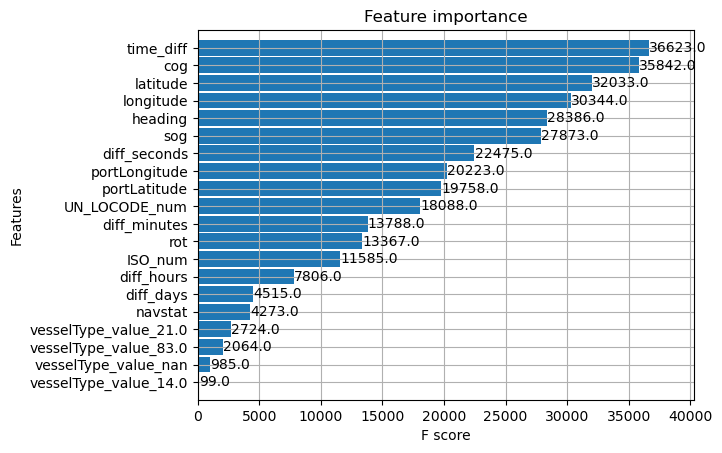

In [74]:
plot_importance(model, height=0.9)

Mde 1
With stuff + prt crdinates

Mde 2
Vessetype nt imprtant 

Mde 3
Away with Minutes, hrs and day with tuned hyperparams